# **CNN classifier (GarNET) Perfomance Evaluation**

Import required packages.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.metrics import classification_report

In [32]:
from garNET import DataSet
from garNET import Classification
from garNET import Plotting

## **Load data and model**

In [33]:
model = Classification.load_model(modelh5="base_modelv03.h5")

data_ZS2102 = DataSet.load_data(Path("Data", "ZS2102_raw"))

metadata = DataSet.load_metadata(Path("Data", "ZS2102_raw"))
scan_dim = metadata["scan_dim"]
centroids = metadata["centroids"][1:,:] # Remove first entry, corrsponding to background
convex_vol = metadata["convex_vol"]

ZS2102_labelled = DataSet.read_classes_from_labelled_set(dataset=Path("Data", "ZS2102_labelled"))

Check out an RGB image of a single grain with plt.imshow().

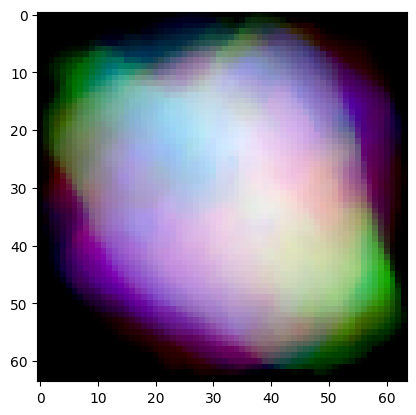

In [34]:
plt.imshow(np.int_(data_ZS2102[1385]))

# **Prediction**

Predict classes with the trained CNN.

In [35]:
raw_predictions = model.predict(data_ZS2102)

classidx_predictions = np.argmax(raw_predictions, axis=1)

ZS2102_predictions = np.empty_like(classidx_predictions, dtype=object)
ZS2102_predictions[classidx_predictions == 0] = "atoll"
ZS2102_predictions[classidx_predictions == 1] = "pitting"
ZS2102_predictions[classidx_predictions == 2] = "intact"
ZS2102_predictions[classidx_predictions == 3] = "multiple"
ZS2102_predictions[classidx_predictions == 4] = "edge"

58/58 [==============================] - 2s 38ms/step


Check the class predicted for the grain shown above.

In [36]:
ZS2102_predictions[1385]

'intact'

In any natural dataset there will be a small proportion of grains with a peculiar geometry that cannot be accounted for in a generalistic training dataset. For the sample ZS-21-02, these were separated into descriptive classes. Here, these classes are combined into a single out-of-distribution (OOD) class in order to compare the CNN's predictions with the human labelled data.

In [37]:
idx_OOD = np.logical_or(np.logical_or(np.logical_or(ZS2102_labelled == "agglomerated", ZS2102_labelled == "fractured"), ZS2102_labelled == "notGarnet"), ZS2102_labelled == "sponge")

ZS2102_labelled[idx_OOD] = "OOD"

## **Classification report**

In [38]:
print(classification_report(ZS2102_labelled, ZS2102_predictions))


              precision    recall  f1-score   support

         OOD       0.00      0.00      0.00        70
       atoll       0.73      0.65      0.69       288
        edge       0.70      0.82      0.76       231
      intact       0.82      0.90      0.86       751
    multiple       0.71      0.87      0.78       257
     pitting       0.49      0.34      0.40       244

    accuracy                           0.74      1841
   macro avg       0.58      0.60      0.58      1841
weighted avg       0.70      0.74      0.72      1841



c:\Users\ThinkPad\anaconda3\envs\GarNET\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ThinkPad\anaconda3\envs\GarNET\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ThinkPad\anaconda3\envs\GarNET\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Comparasion: CNN vs. human**

Compare the resulting MSD and CSD from the CNN classification with the human labelled data.

In [39]:
# filter out grains with the shapes: "edge", "multiple" and "OOD" (only in labelled set)
# 1. from labelled dataset
filter_shapes = np.logical_and(np.logical_and(ZS2102_labelled != "edge", ZS2102_labelled != "multiple"), ZS2102_labelled != "OOD")

ZS2102_labelled_filtered = ZS2102_labelled[filter_shapes]
convex_vol_ZS2102_labelled_filtered = convex_vol[filter_shapes]
centroids_ZS2102_labelled_filtered = centroids[filter_shapes]

# 2. from predictions
filter_shapes = np.logical_and(ZS2102_predictions != "edge", ZS2102_predictions != "multiple")

ZS2102_predictions_filtered = ZS2102_predictions[filter_shapes]
convex_vol_ZS2102_predictions_filtered = convex_vol[filter_shapes]
centroids_ZS2102_predictions_filtered = centroids[filter_shapes]

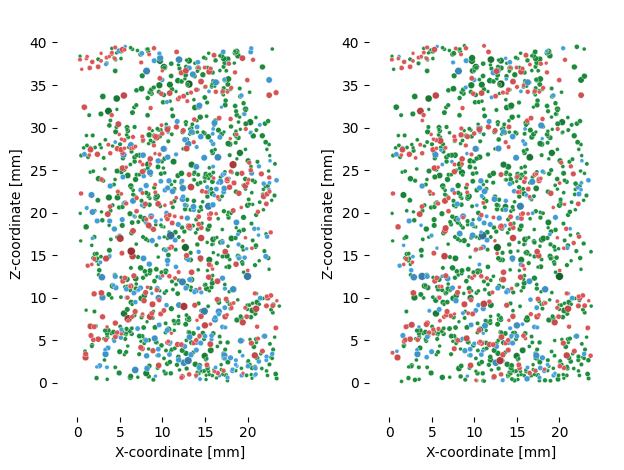

In [40]:
fig, axs = plt.subplots(1, 2)

Plotting.projection(centroids=centroids_ZS2102_labelled_filtered, scan_dim=scan_dim, vx_cts=convex_vol_ZS2102_labelled_filtered,
                    shape_classes=ZS2102_labelled_filtered, res_in_mm=0.018, shapes_of_interest=["intact", "pitting", "atoll"],
                    x="X", y="Z", color_shape_classes=[["#1D913E", "#105223"], ["#43A2DE", "#336D91"], ["#DE5959", "#912C2C"]], ax=axs[0])

Plotting.projection(centroids=centroids_ZS2102_predictions_filtered, scan_dim=scan_dim, vx_cts=convex_vol_ZS2102_predictions_filtered,
                    shape_classes=ZS2102_predictions_filtered, res_in_mm=0.018, shapes_of_interest=["intact", "pitting", "atoll"],
                    x="X", y="Z", color_shape_classes=[["#1D913E", "#105223"], ["#43A2DE", "#336D91"], ["#DE5959", "#912C2C"]], ax=axs[1])

axs[0].legend().set_visible(False)
axs[1].legend().set_visible(False)

fig.tight_layout()

plt.show()

0.040768042196107634
0.040768042196107634
0.0409277891574975
0.0409277891574975


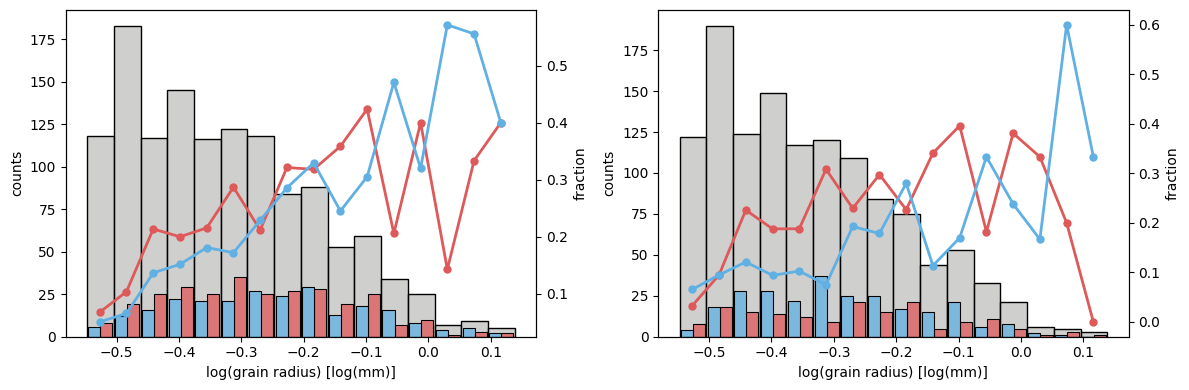

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

Plotting.crystal_size_distribtuion(vx_cts=convex_vol_ZS2102_labelled_filtered, shape_classes=ZS2102_labelled_filtered,
                          res_in_mm=0.018, shapes_of_interest=["atoll", "pitting"], log=True,
                          ax=axs[0], color_all="#C0BFBE", color_shape_classes=["#60B0E3", "#DE5959"])

tax1 = axs[0].twinx()

Plotting.class_fraction_in_CSD(vx_cts=convex_vol_ZS2102_labelled_filtered, shape_classes=ZS2102_labelled_filtered,
                      res_in_mm=0.018, shapes_of_interest=["atoll", "pitting"], log=True,
                      ax=tax1, color_shape_classes=["#DE5959", "#60B0E3"])


Plotting.crystal_size_distribtuion(vx_cts=convex_vol_ZS2102_predictions_filtered, shape_classes=ZS2102_predictions_filtered,
                          res_in_mm=0.018, shapes_of_interest=["atoll", "pitting"], log=True,
                          ax=axs[1], color_all="#C0BFBE", color_shape_classes=["#60B0E3", "#DE5959"])

tax2 = axs[1].twinx()

Plotting.class_fraction_in_CSD(vx_cts=convex_vol_ZS2102_predictions_filtered, shape_classes=ZS2102_predictions_filtered,
                      res_in_mm=0.018, shapes_of_interest=["atoll", "pitting"], log=True,
                      ax=tax2, color_shape_classes=["#DE5959", "#60B0E3"])

axs[0].legend().set_visible(False)
axs[1].legend().set_visible(False)

tax1.legend().set_visible(False)
tax2.legend().set_visible(False)

fig.tight_layout()

plt.show()

# **Monte-Carlo simulation of random classifier base line**

Two cases of random classifiers are simulated to have a base line to compare the trained model to:
1. ***A naive random classifier:***\
Uniform (equal) probability of predicting each class.
2. ***An informed random classifier:***\
Probability of predicting each class equal to the proportion of that class in the dataset.

In [42]:
# set number of simulations
n_sims = 2000

In [43]:
class_labels, counts = np.unique(ZS2102_labelled, return_counts=True)

### **Naive random classifier**

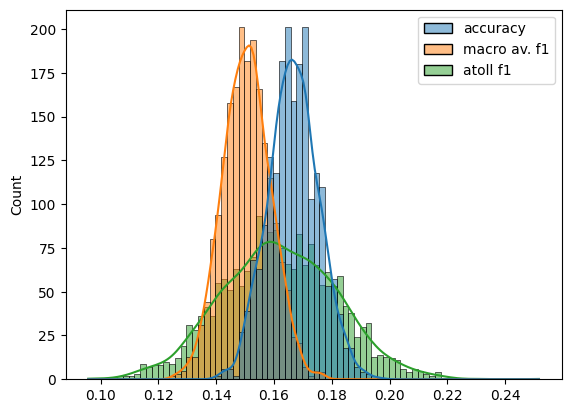

In [44]:
accuracy_eq_prob = np.zeros(n_sims)
macro_f1_eq_prob = np.zeros(n_sims)

atoll_f1_eq_prob = np.zeros(n_sims)

for i in range(n_sims):
    # generate random array with equal of class_labels and same length as true_classes
    rng = np.random.default_rng()
    random_classes = rng.choice(class_labels, size=len(ZS2102_labelled))

    metrics = classification_report(ZS2102_labelled, random_classes, output_dict=True)
    accuracy_eq_prob[i] = metrics["accuracy"]
    macro_f1_eq_prob[i] = metrics["macro avg"]["f1-score"]
    atoll_f1_eq_prob[i] = metrics["atoll"]["f1-score"]

sns.histplot(data={"accuracy": accuracy_eq_prob, "macro av. f1": macro_f1_eq_prob, "atoll f1": atoll_f1_eq_prob},
             binwidth=0.002, kde=True, stat="count")
plt.show()

### **Informed random classifier**

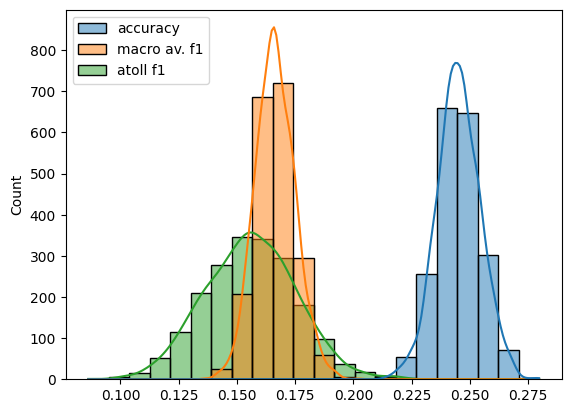

In [45]:
accuracy_var_prob = np.zeros(n_sims)
macro_f1_var_prob = np.zeros(n_sims)

atoll_f1_var_prob = np.zeros(n_sims)

for i in range(n_sims):
    # generate random array with same counts of class_labels and same length as true_classes
    rng = np.random.default_rng()
    random_classes = rng.choice(class_labels, size=len(ZS2102_labelled), p=counts/len(ZS2102_labelled))

    metrics = classification_report(ZS2102_labelled, random_classes, output_dict=True)
    accuracy_var_prob[i] = metrics["accuracy"]
    macro_f1_var_prob[i] = metrics["macro avg"]["f1-score"]
    atoll_f1_var_prob[i] = metrics["atoll"]["f1-score"]


sns.histplot(data={"accuracy": accuracy_var_prob, "macro av. f1": macro_f1_var_prob, "atoll f1": atoll_f1_var_prob},
             kde=True, stat="count")
plt.show()

## **Figure S2: CNN vs. random classifier**

In [48]:
# pack all metrics into a dataframe with the columns holding the metrics values, what metric it is, and the probability
# distribution used
df = pd.DataFrame({"metric_value": np.concatenate((accuracy_eq_prob, accuracy_var_prob,
                                                   macro_f1_eq_prob, macro_f1_var_prob,
                                                   atoll_f1_eq_prob, atoll_f1_var_prob)),
                   "metric": np.concatenate((np.full(2*n_sims, "Accuracy"),
                                             np.full(2*n_sims, "Macro av. F1"),
                                             np.full(2*n_sims, "Atoll F1"))),
                   "probability": np.concatenate((np.full(n_sims, "Equal class probability"), np.full(n_sims, "Frequency informed class probability"),
                                                  np.full(n_sims, "Equal class probability"), np.full(n_sims, "Frequency informed class probability"),
                                                  np.full(n_sims, "Equal class probability"), np.full(n_sims, "Frequency informed class probability")))
                   })


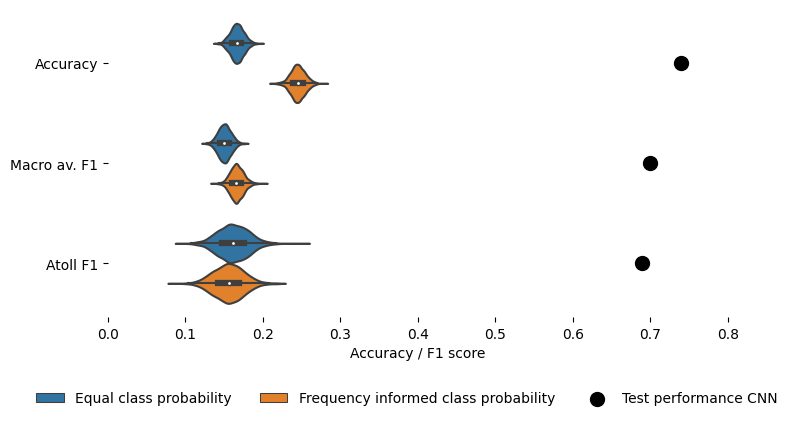

In [49]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(data=df, x="metric_value", y="metric", hue="probability", ax=ax)

ax.scatter(y=[0, 1, 2], x=[0.74, 0.70, 0.69], label="Test performance CNN", marker="o", color="black", s=100)
ax.set_xlabel("Accuracy / F1 score")
ax.set_ylabel(None)
ax.set_xlim(0.0, 0.8)

ax.set_frame_on(False)

ax.legend(frameon=False, bbox_to_anchor=(1.1, -0.20), ncol=3)